# Running with helper class

[This note-book is in oceantracker/tutorials_how_to/]

Oceantracker is designed so that both coders and non-coders can get almost the same level of adaptability to their specific needs. Also to streamline running many cases across distributed computers, along with enabling online particle tracking as a service. 

To achieve these capabilities, it uses parameters to both change the settings to meet the users needs, but also to build the computational pipeline for the users specific needs. This flexibility in the computational pipeline is achieved using "class" parameters. 

Classes perform specific roles in the pipeline. Parameters tell Oceantracker which version of core classes the user wants to use for each role, or add optional classes. Eg. add multiple "release_groups" classes, which may release particles at points, or within a polygon, at different times, rates and locations, all within the same computational run.  

Simply by changing the parameters, users can load their own version of a class, including the "solver" class which orchestrates the time stepping and operations by other classes. There are  base classes  for all the major roles within the computational pipeline. Classes can be adapted by inheriting the bases class, or one of its children, and overwriting some of the methods to alter how the class performs its role.

To make the ideas of settings and classes easier to adopt, the below uses methods of a helper class to add settings and classes to the pipeline. The notebook E_run_using_parameter_dictionaries.ipynb, shows how run directly from parameter dictionaries, which are built in code or read from a json or yaml file. 

## Parameters using helper

There are two types of parameters:

  1. Settings parameters
  
 These are set with one or more calls to helper method, ot.setting(...), where ... are keyword arguments.  eg "time_step", the model time step in seconds is set using,  time_step= 1800.

  There are default values for most settings. A full set of settings and their defaults is at [all settings](https://oceantracker.github.io/oceantracker/_build/html/info/parameter_ref/settings.html)

  2. Class role parameters 
      
  Classes add specific tasks to the computational pipeline, eg. how to release particles, write output, particle suspension etc. These are added using helper method ot.add_class(class_role, ....).  The first argument is a "class_role". Each class has its own specific settings, which are set using keyword arguments of helper method. Eg. ot.add_class('reader', input_dir= 'my_hindcast_dir',  ....) adds a reader class and tells is it which folder contains the hindcast files.
  
  A full set of classes and their default settings is at [parameter_ref](https://oceantracker.github.io/oceantracker/_build/html/info/parameter_ref/parameter_ref_toc.html)

  Normally there must be a keyword argument "class_name" setting. This is used to import the required class into the computational pipeline, with its specific settings. This "class_name" is a string, used to import the class at setup (so is the same as that used to import any python class within a module).
  
  The "class_name" setting is normally required.   A few  class_roles have a default class_name, eg. in minimal_example "release_groups" assumes a point_release, and the reader's "class_name" is chosen by looking at variable names within the hindcast's netcdf file. 

There are two types of "class_role".

When

  a) Only a single class is required, these have singular "class_role", eg."reader" and  "solver". 

  b) One or more classes can be added. These have plural "class_role" (eg. can add multiple "release_groups"). Users must give a unique  name to each one.
        
Documentation for all parameters/settings and their default values.

Add link here <add links to docs>

## Extend the minimal example

The below extends the minimal_example, it adds:

  - release at random locations within a polygon, at random water depths (the default)

  - a particle fall velocity 

  - particles on the bottom are re-suspended if friction velocity exceeds a critical value. 



In [5]:
# build parameters using helper class
from oceantracker.main import OceanTracker

ot = OceanTracker() # make an instance of the helper class

# one or more settings can be set by calls to os.settings
ot.settings(output_file_base='param_test1',# name used as base for output files
            root_output_dir='output' #  output is put in dir   'root_output_dir'/'output_file_base'
            )
# ot.settings can be used more than once to add more settings
ot.settings(time_step =120) #  2 min model time step as seconds  

# add a compulsory reader class
# no class_name setting is required 
# as will detect that it needs a a schism reader class
ot.add_class('reader', #  class_role is reader
            input_dir= '../demos/demo_hindcast',  # folder to search for hindcast files, sub-dirs will, by default, also be searched
            file_mask = 'demoHindcastSchism*.nc',    # the file mask of the hindcast files
            )

# add some release groups
# release_groups are one or more release groups 
#     (ie locations where particles are released at the same times and locations) 
# there must be at least one release group

# add  release locations from two points,
ot.add_class('release_groups',  #  class_role is release_groups
            name ='my_release_points1', 
                # the required name setting, is used to refer to this release group internally anf in postprocsing
            points= [[1595000, 5482600],
                    [1599000, 5486200]],      # must be an N by 2 or 3 or list, convertible to a numpy array
                    release_interval= 3600,           # seconds between releasing particles
                    pulse_size = 10,                   # number of particles released each release_interval
                    # no class_name setting, so default is a point release
                    ) 
# add a second release group, from random locations within a polygon
ot.add_class('release_groups', #  class_role is release_group
            name ='my_polygon_release1',
            class_name= 'PolygonRelease', # use a polygon release
            # this time is a polygon , so below points are polygon cords
            points = [  [1597682.1237, 5489972.7479],
                        [1598604.1667, 5490275.5488],
                        [1598886.4247, 5489464.0424],
                        [1597917.3387, 5489000],
                        [1597300, 5489000],
                        [1597682.1237, 5489972.7479]
                    ],
            release_interval= 7200,    # seconds between releasing particles
            pulse_size = 20,                   # number of particles released each release_interval
            )    

# alter default re-suspension class's default settings
ot.add_class('resuspension', critical_friction_velocity = .005) # only re-suspend particles if friction vel. exceeds this value

# add a class to modify the particle velocity           
# velocity_modifiers are a set of velocities added to  water velocity given in the hydrodynamic model's 
# here a fall velocity with a given  value is added to the computation 
ot.add_class('velocity_modifiers',  #  class_role is velocity_modifiers
             name ='my_fall_velocity',
            class_name = 'TerminalVelocity', 
            value= -0.001, # mean terminal vel < 0 for falling
            # optionally variance can also be use to give each particle its own fall velocity 
            )

helper --------------------------------------------------------------------------
helper Starting OceanTracker helper class


## Running OceanTracker

There are several ways to run OceanTracker 
    
1) By coding 
    - user "class helper" method to build parameters (as above)  then run
    - build parameters dictionary in code then run
    - read parameter file and then run  

2) Without coding

    - run from command line with parameter file which is built by editing a json/yaml text file

Here we use the "class helper" method approach, the other ways to run directly using parameter dictionaries  outlined in E_run_using_parameter_dictionaries.ipynb, add link...

Note:

There are many ways to run the code, eg. with IDE like Pycharm, Visual Studio Code. It can also, as here, be run in iPython notebooks. However the way notebooks are implemented can sometimes result in issues.

See ... for more details

Below runs oceantracker using the helper class.

## See all parameters

In [6]:
# first see the parameters build using the helper class instance
# this is a dictionary ot.params
print(ot.params)  # ugly!

# use json.dumps() to make it pretty
import json 
print(json.dumps(ot.params, indent=4))

# lots of params are shown 
# as filling a template given by from user callable main.param_template() 
# null or None are optional ones which will use defaults

{'output_file_base': 'param_test1', 'root_output_dir': 'output', 'time_step': 120, 'reader': {'input_dir': '../demos/demo_hindcast', 'file_mask': 'demoHindcastSchism*.nc'}, 'release_groups': {'my_release_points1': {'points': [[1595000, 5482600], [1599000, 5486200]], 'release_interval': 3600, 'pulse_size': 10}, 'my_polygon_release1': {'class_name': 'PolygonRelease', 'points': [[1597682.1237, 5489972.7479], [1598604.1667, 5490275.5488], [1598886.4247, 5489464.0424], [1597917.3387, 5489000], [1597300, 5489000], [1597682.1237, 5489972.7479]], 'release_interval': 7200, 'pulse_size': 20}}, 'resuspension': {'critical_friction_velocity': 0.005}, 'velocity_modifiers': {'my_fall_velocity': {'class_name': 'TerminalVelocity', 'value': -0.001}}}
{
    "output_file_base": "param_test1",
    "root_output_dir": "output",
    "time_step": 120,
    "reader": {
        "input_dir": "../demos/demo_hindcast",
        "file_mask": "demoHindcastSchism*.nc"
    },
    "release_groups": {
        "my_release_p

## Start run using helper

In [7]:
# now run oceantracker 
# as helper "ot" has set params above, simply run it

case_info_file_name = ot.run()

# output now in folder "root_output_dir"/"output_file_base"
# in this example output is in directory  output/param_test1'

# case_info_file_name is the name of a json file with useful for post processing, 
# eg it holds output file names to assist in reading and plotting data
print('case file name=',case_info_file_name)

helper   - Starting run using helper class
Main --------------------------------------------------------------------------
Main OceanTracker starting main:
Main   - Output dir set up.
Main >>> Warning: Deleted contents of existing output dir
Main     >>> Note: to help with debugging, parameters as given by user  are in "param_test1_raw_user_params.json"
Main   Output is in dir "e:\H_Local_drive\ParticleTracking\oceantracker\tutorials_how_to\output\param_test1"
Main         hint: see for copies of screen output and user supplied parameters, plus all other output
Main --------------------------------------------------------------------------
Main  OceanTracker version 0.5.0.000 2024-03-07 - preliminary setup
Main      Python version: 3.10.10 | packaged by conda-forge | (main, Mar 24 2023, 20:00:38) [MSC v.1934 64 bit (AMD64)]
Main   - Found input dir "../demos/demo_hindcast"
Main   - found hydro-model files of type  "SCHISIM"
Main       -  sorted hyrdo-model files in time order,	  0.025 

## Basic plots of tracks

also see ... for more on plotting notebook

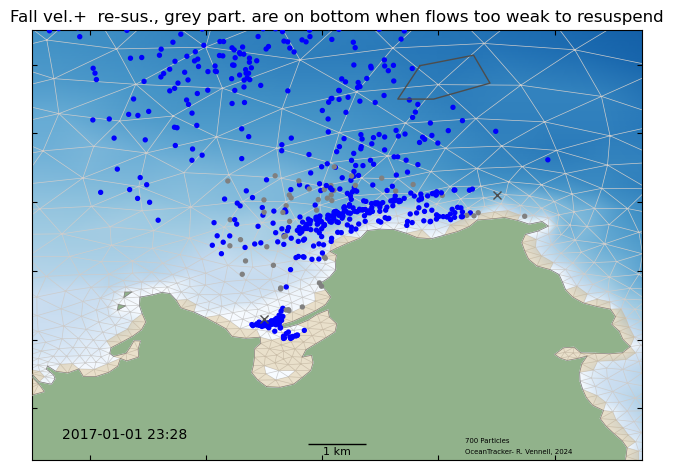

In [8]:
# plot animation of results
from matplotlib import pyplot as plt
from plot_oceantracker.plot_tracks import animate_particles
from read_oceantracker.python import  load_output_files
from IPython.display import HTML # show animation in note book

# read particle track data into a dictionary using case_info_file_name
tracks = load_output_files.load_track_data(case_info_file_name)

ax= [1591000, 1601500, 5478500, 5491000]  # area to plot
# animate particles
anim = animate_particles(tracks, axis_lims=ax,title='Fall vel.+  re-sus., grey part. are on bottom when flows too weak to resuspend', 
                         show_dry_cells=True, show_grid=True, show=False) # use ipython to show video, rather than matplotlib plt.show()

# this is slow to build! 
HTML(anim.to_html5_video())